<a href="https://colab.research.google.com/github/jxie5189/BrainCT_CNN_Model/blob/main/CNN_BrainCT_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

#Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Processing data -> obtain paths and labels into a DataFrame
##Reference:https://www.kaggle.com/code/metamadyeth/ml-project-image-classification for data processing

In [ ]:
#Reference: https://www.kaggle.com/code/metamadyeth/ml-project-image-classification

#brain_ct folder in driver, folder contains 3 folder, each folder has diffrent condition
base_dir = "/content/drive/MyDrive/Colab Notebooks/ct_brain"

class_folder_names = os.listdir(base_dir)
class_folder_names.remove('.DS_Store')
print(class_folder_names)

print()

data = []

#for each different condition, for each files in the condition folder, if it's a picture('jpg'),
#add the direct path into the images
for folder in class_folder_names:
  for fileName in os.listdir(base_dir+'/'+folder):
    if fileName.__contains__('jpg'):
      data.append({'path':os.path.join(base_dir, folder, fileName), 'label':folder})

print(data[0])

data_df = pd.DataFrame(data)

data_df.head()

['tumor', 'aneurysm', 'cancer']

{'path': '/content/drive/MyDrive/Colab Notebooks/ct_brain/tumor/11.jpg', 'label': 'tumor'}


,path,label
0,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor
1,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor
2,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor
3,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor
4,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor


#Make imageDisplay function when given a path

In [ ]:
from IPython.display import display as IpyDisplay, Image as IpyImage

def displayCT(path):
  image_path = path
  return IpyDisplay(IpyImage(filename=image_path))

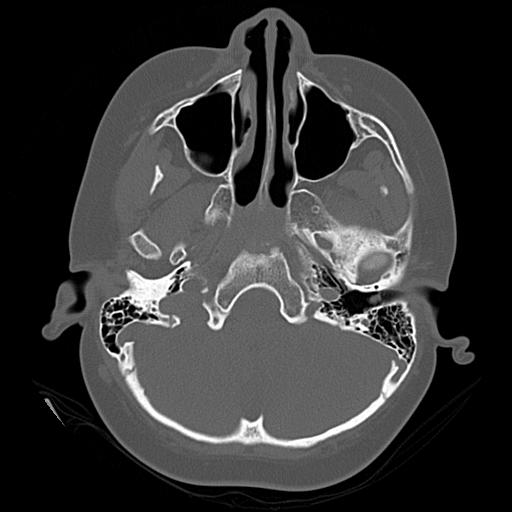

In [ ]:
image_1 = data_df['path'].loc[0]

displayCT(image_1)

#Convert labels into numerical values for NN

In [ ]:
label_map = {'tumor':0, 'aneurysm':1, 'cancer':2}

data_df['label_num'] = data_df['label'].replace(label_map)

data_df.head()

,path,label,label_num
0,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0
1,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0
2,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0
3,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0
4,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0


#Use Tensorflow and Pillow to convert image into array
##moidified to intake any non-training set image shape
##reference: https://www.kaggle.com/code/metamadyeth/ml-project-image-classification

In [ ]:
#Reference: https://www.kaggle.com/code/metamadyeth/ml-project-image-classification

from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image as PILImage
from PIL import ImageOps

def processImage(path, target_size = (512, 512)):
  i = PILImage.open(path)
  if i.size != target_size:
    i = ImageOps.pad(i, target_size, method=0, color=None)
  img_array = img_to_array(i)/255 #normlization
  return i

In [ ]:
data_df['image_array'] = data_df['path'].apply(processImage)

data_df.head()

,path,label,label_num,image_array
0,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


#Split Training and Test set

In [ ]:
x = np.array(data_df['image_array'].tolist())
y = data_df['label_num']

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                            test_size=0.2,
                                            random_state=45)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(207, 512, 512, 3)
(207,)
(52, 512, 512, 3)
(52,)


#Make CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

#original model was with 3 convolutional layers  with an epoch of 5, but 2 layers and epoch of 3 produces >98% accuracy as well.

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Conv2D(128, (3, 3), activation='relu'),
    # MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model

y_train_one_hot = to_categorical(y_train, num_classes=3)

model_cnn.fit(x_train, y_train_one_hot, epochs=3)

Epoch 1/3
7/7 [==============================] - 97s 13s/step - loss: 5.5725 - accuracy: 0.6280
Epoch 2/3
7/7 [==============================] - 96s 14s/step - loss: 0.1420 - accuracy: 0.9565
Epoch 3/3
7/7 [==============================] - 92s 13s/step - loss: 0.0937 - accuracy: 0.9855


#Test set evaluation

In [ ]:
y_test_one_hot = to_categorical(y_test, num_classes=3)

model_cnn.evaluate(x_test, y_test_one_hot, verbose=2)

2/2 - 8s - loss: 0.0913 - accuracy: 0.9808 - 8s/epoch - 4s/step


[0.0913325622677803, 0.9807692170143127]

#Convert back to label from model output

In [ ]:
def model_translate(model_output, labelmap):

  labels = [labels for labels in labelmap]

  normalized_probabilities = np.exp(model_output) / np.sum(np.exp(model_output), axis=1, keepdims=True)

  finalOutput_df = pd.DataFrame({'Condition':labels, 'Percentage':normalized_probabilities[0]})

  highest_precentage = round(finalOutput_df['Percentage'].max()*100, 2)

  highest_percentage_idx = finalOutput_df['Percentage'].idxmax()

  predicted_class = finalOutput_df['Condition'].iloc[highest_percentage_idx]

  print(f'The predicted class for the image is {predicted_class} with {highest_precentage}% confidence')
  print()
  print('Total Predication and Percentage')
  print(finalOutput_df)
  return finalOutput_df

#Make Application
##make application object

In [ ]:

class NeuroCTScanner:
  def loadModel(self,model):
    self.model = model

  def evaluateImage(self, image_path):
    ready_image = self.__convert_image__(image_path)
    result = self.model(ready_image)
    self.displayImage(image_path)
    return model_translate(result, label_map)

  def __convert_image__(self, image_path):
    image = processImage(image_path)
    image_array = np.asarray(image)
    ready_image = np.expand_dims(image_array, axis = 0)
    return ready_image

  def displayImage(self, image_path):
    path = image_path
    return IpyDisplay(IpyImage(filename=image_path))


In [ ]:
neuroCtScanner = NeuroCTScanner()

##Load neural network into the object

In [ ]:
neuroCtScanner.loadModel(model_cnn)

In [ ]:
test1 = data_df['path'].iloc[0]
test1

'/content/drive/MyDrive/Colab Notebooks/ct_brain/tumor/11.jpg'

##test image

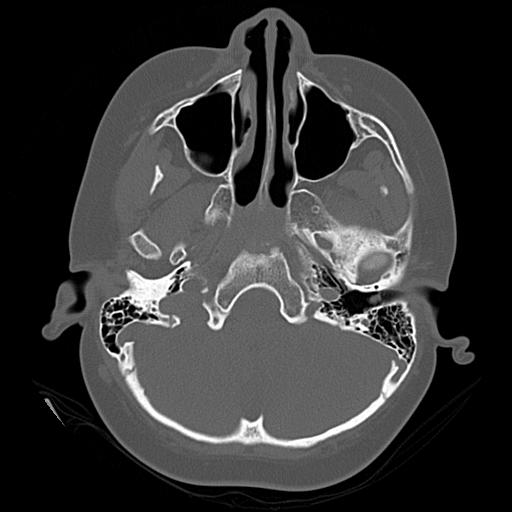

The predictd class for the image is tumor with 57.61% confidence

Total Predication and Percentage
  Condition  Percentage
0     tumor    0.576117
1  aneurysm    0.211942
2    cancer    0.211942


,Condition,Percentage
0,tumor,0.576117
1,aneurysm,0.211942
2,cancer,0.211942


In [ ]:
neuroCtScanner.evaluateImage(test1)

#Random Sample Testing

In [ ]:
data_df.head()

,path,label,label_num,image_array
0,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,/content/drive/MyDrive/Colab Notebooks/ct_brai...,tumor,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


##Make Samples with same randomlization

In [131]:
x_train, x_test,y_train, y_test = train_test_split(data_df['path'], data_df['label'], test_size=0.2, random_state=45)

In [124]:
test_df = [x_test, y_test]

In [132]:
test_df = pd.concat([x_test, y_test], axis=1)

In [136]:
random_samples = test_df.sample(3)
sample_1 = random_samples.iloc[0]
sample_2 = random_samples.iloc[1]
sample_3 = random_samples.iloc[2]


In [137]:
sample_1

path     /content/drive/MyDrive/Colab Notebooks/ct_brai...
label                                               cancer
Name: 235, dtype: object

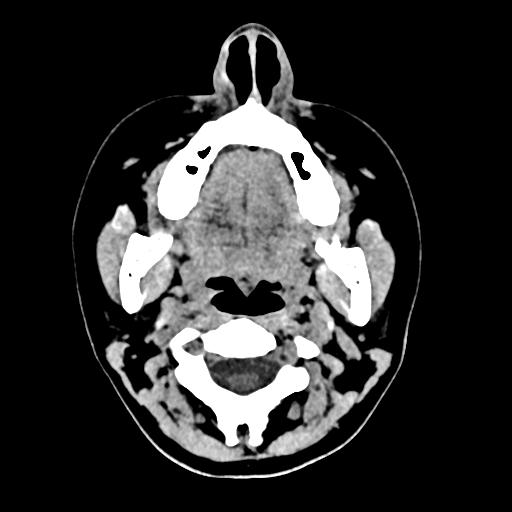

The predicted class for the image is cancer with 57.61% confidence

Total Predication and Percentage
  Condition  Percentage
0     tumor    0.211942
1  aneurysm    0.211942
2    cancer    0.576117

Sample 1 actual label is cancer


In [138]:
neuroCtScanner.evaluateImage(sample_1['path'])
print()
print('Sample 1 actual label is '+sample_1['label'])

In [139]:
sample_2['path']

'/content/drive/MyDrive/Colab Notebooks/ct_brain/tumor/2.jpg'

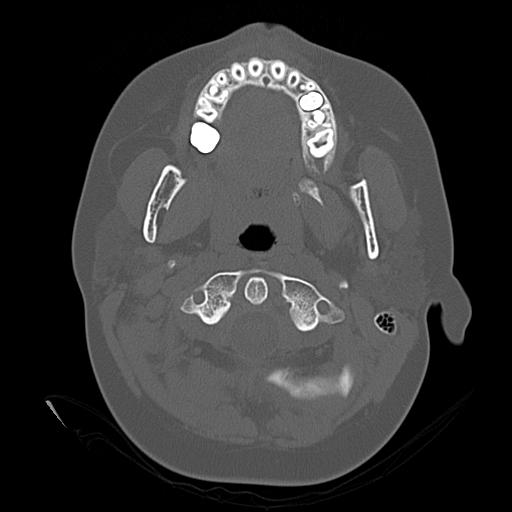

The predicted class for the image is tumor with 57.61% confidence

Total Predication and Percentage
  Condition  Percentage
0     tumor    0.576117
1  aneurysm    0.211942
2    cancer    0.211942

Sample 2 actual label is tumor


In [140]:
neuroCtScanner.evaluateImage(sample_2['path'])
print()
print('Sample 2 actual label is '+sample_2['label'])

In [141]:
sample_3['path']

'/content/drive/MyDrive/Colab Notebooks/ct_brain/cancer/58.jpg'

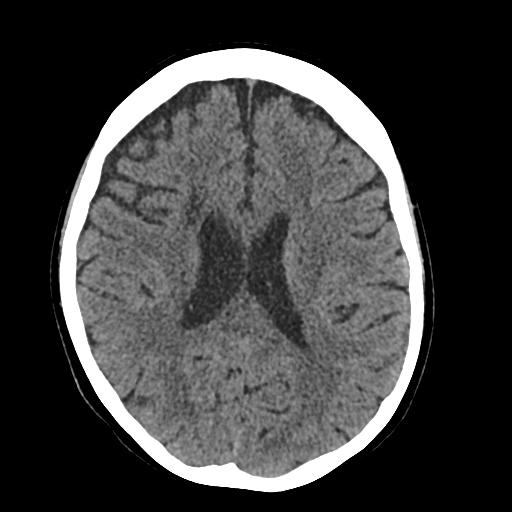

The predicted class for the image is cancer with 57.61% confidence

Total Predication and Percentage
  Condition  Percentage
0     tumor    0.211942
1  aneurysm    0.211942
2    cancer    0.576117

Sample 3 actual label is cancer


In [142]:
neuroCtScanner.evaluateImage(sample_3['path'])
print()
print('Sample 3 actual label is '+sample_3['label'])

#Future work:
##using random image from the internet

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/CT-scan-image-of-brain-tumor.jpg'

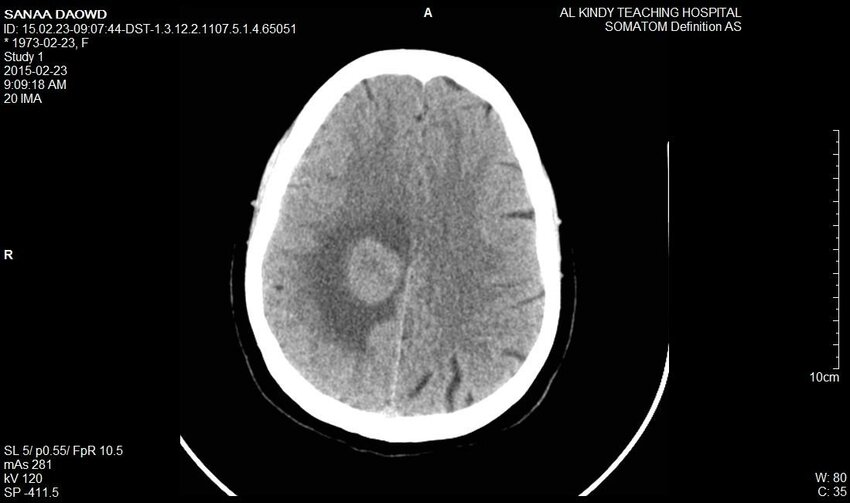

The predictd class for the image is tumor with 57.61% confidence

Total Predication and Percentage
  Condition  Percentage
0     tumor    0.576117
1  aneurysm    0.211942
2    cancer    0.211942


,Condition,Percentage
0,tumor,0.576117
1,aneurysm,0.211942
2,cancer,0.211942


In [ ]:
neuroCtScanner.evaluateImage(path)